In [1]:
import numpy as np
import networkx as nx



# Question 1

In [63]:
class ErdosRenyi:

    def __init__(self, number_of_nodes, number_of_edges):
        '''
        m => number of nodes
        n => number of edges
        '''
        self.m = number_of_nodes
        self.n = number_of_edges



    def create_graph(self):
        all_candidates = np.array([(i, j) for i in range(self.m) for j in range(self.m) if i != j])

        chosen_indices = np.random.choice(len(all_candidates), self.n, replace=False)

        self.graph = nx.from_edgelist(all_candidates[chosen_indices])

    def plot_graph(self):
        nx.draw(self.graph)





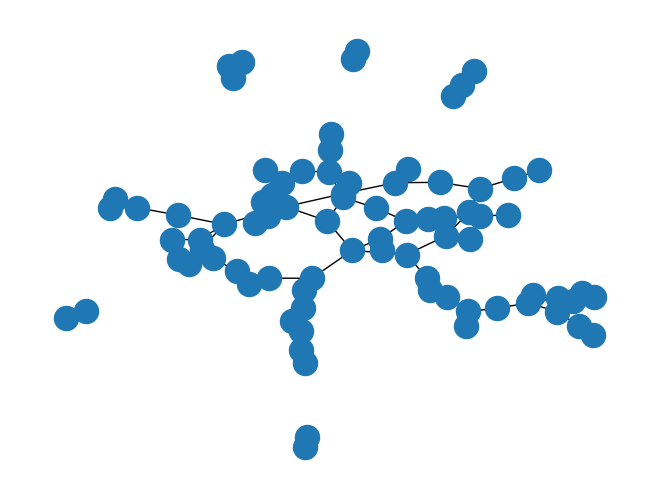

In [101]:
m = 100
n = 85
obj = ErdosRenyi(m, n)
obj.create_graph()
obj.plot_graph()

In [29]:
m, n = 3, 3

a = np.array([(i, j) for i in range(m) for j in range(m) if i != j])
chosen_indices = np.random.choice(len(a), n, replace=False)

In [30]:
chosen_indices

array([1, 3, 4])

In [31]:
a

array([[0, 1],
       [0, 2],
       [1, 0],
       [1, 2],
       [2, 0],
       [2, 1]])

In [32]:
a[chosen_indices]

array([[0, 2],
       [1, 2],
       [2, 0]])